## Natural Language Processing with Disaster Tweets

#### Predict which Tweets are about real disasters and which ones are not

Competition Description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

Acknowledgments

This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

### Strategy:

##### I will attempt to use an off the shelf DistilBERT Model from Hugging Face to make the predictions. The data will need to be processed accordingly so that I may fine tune the Model correctly. I will then check and see if the predictions made are accurate. 

1. Data Preprocessing: An original training data csv has been provided but I will still need to split the training data in order to evaluate the model's performance. I will then use the DistilBERT Tokenizer to tokenize both training and test data being sure to do some padding and including the attention mask for the pretrained model.
<br />
<br />
2. I will then compile the pretrained model and train it with the prepared data (Fine Tuning) for a minimum of three epochs. The model's performance will then be evaluated. I plan to make my own function that takes a tweet as an input and outputs a binary response (Disaster or not Disaster) using the fine tuned model. In this way I can test how it responds to real world data. 


In [1]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np

In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
from transformers import TFDistilBertForSequenceClassification

In [5]:
import tensorflow as tf

In [6]:
# Load the dataset into a Pandas DataFrame
original_test_data = pd.read_csv('nlp-getting-started/test.csv')
training_data = pd.read_csv('nlp-getting-started/train.csv')

# Split the dataset into training, validation, and testing sets
train_df, test_df = train_test_split(training_data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(training_data, test_size=0.2, random_state=42)

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Preprocess the text data
def preprocess(text):
    # Tokenize the text into a sequence of tokens
    tokens = tokenizer.encode_plus(text,
                                    add_special_tokens=True,
                                    max_length=128,
                                    pad_to_max_length=True,
                                    return_attention_mask=True,
                                    return_token_type_ids=False)
    return np.array(tokens['input_ids']), np.array(tokens['attention_mask'])

train_text = train_df['text'].apply(preprocess)
val_text = val_df['text'].apply(preprocess)
test_text = test_df['text'].apply(preprocess)

train_input_ids = np.vstack(train_text.apply(lambda x: x[0]))
train_attention_masks = np.vstack(train_text.apply(lambda x: x[1]))

val_input_ids = np.vstack(val_text.apply(lambda x: x[0]))
val_attention_masks = np.vstack(val_text.apply(lambda x: x[1]))

test_input_ids = np.vstack(test_text.apply(lambda x: x[0]))
test_attention_masks = np.vstack(test_text.apply(lambda x: x[1]))

train_labels = train_df['target'].values
val_labels = val_df['target'].values
test_labels = test_df['target'].values

# Build the DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Train the model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=loss)
history = model.fit([train_input_ids, train_attention_masks],
                    train_labels,
                    validation_data=([val_input_ids, val_attention_masks], val_labels),
                    epochs=3,
                    batch_size=32)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\matthewgomez\miniconda3\envs\disaster_nlp\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some layers from the model checkpoint at distilbert-base-uncased were 

Epoch 1/3
191/191 [==============================] - 1224s 6s/step - loss: 0.4400 - val_loss: 0.3906
Epoch 2/3
191/191 [==============================] - 1236s 6s/step - loss: 0.3146 - val_loss: 0.4059
Epoch 3/3
191/191 [==============================] - 1262s 7s/step - loss: 0.2095 - val_loss: 0.4505


#### Note:
The training did not take very long comparing it to fine tuning a full BERT Model. (It took about one hour) The initial results look quite promising, seeing as the loss was reduced by a fair amount every epoch. 

In [7]:
# Evaluate the model on the test set
test_preds = model.predict([test_input_ids, test_attention_masks])
test_preds = np.argmax(test_preds.logits, axis=-1)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)
print('Test Accuracy:', test_accuracy)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1 Score:', test_f1)

48/48 [==============================] - 84s 2s/step
Test Accuracy: 0.8220617202889035
Test Precision: 0.7925696594427245
Test Recall: 0.7889060092449923
Test F1 Score: 0.7907335907335907


#### Note:
The results are fairly good, with an accuracy score of over 80 percent, I do expect the model to predict tweets fairly well. Of more concern is the F1 Score which is also fairly good. This means the model is making accurate positive and negative predictions. I'm excited to see how well it does on real world data. 

Text(103.24999999999999, 0.5, 'Actual')

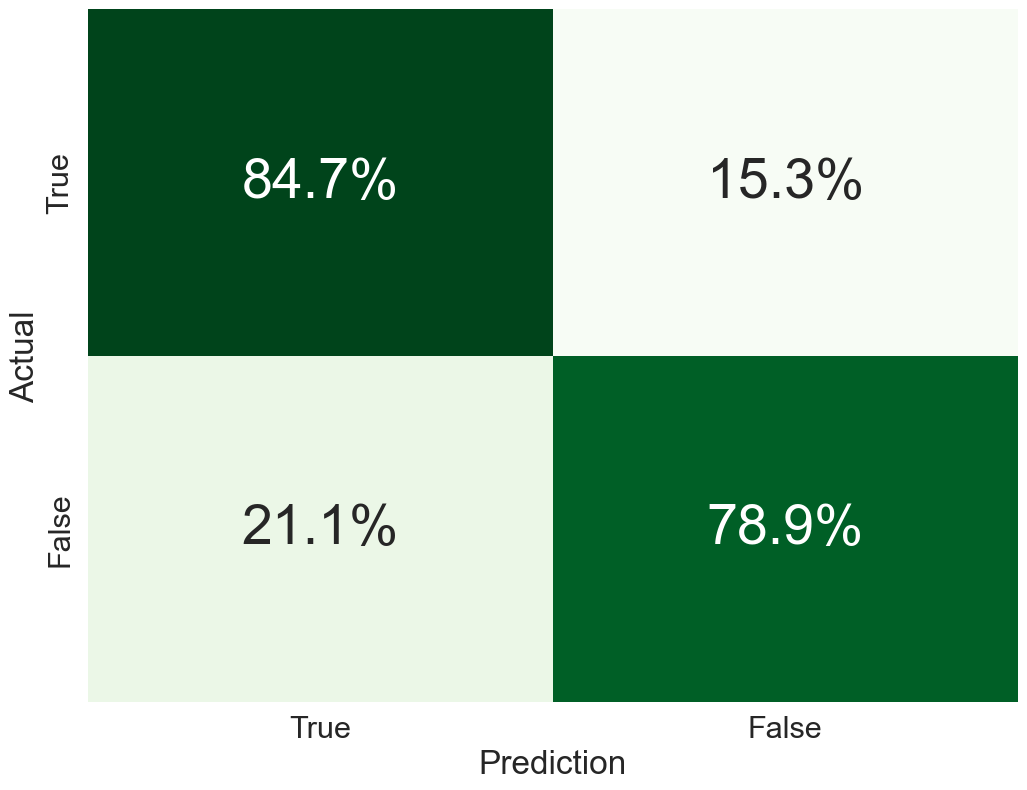

In [8]:
# Generate Confusion Matrix
cm = confusion_matrix(test_labels, test_preds, normalize = "true")

plt.figure(figsize = (12, 9))
sns.set(font_scale = 2)

ax = sns.heatmap(cm, annot = True, 
                xticklabels = ['True', 'False'],
                yticklabels = ['True', 'False'],
                cbar = False, cmap = 'Greens',
                fmt = '.1%', annot_kws = {"fontsize":40})
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")

#### Note:
As expected, it would seem the model is fairly accurate at predicting both Disaster and Non-Disaster Tweets. It does seem to be making more false positive predictions which might be expected as the data has slightly more positive (Disaster Tweets) than Non Disaster Tweets. This could perhaps be improved if the target labels in the data were more balanced.

In [9]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


#### Note:
A powerful little transformer model.

In [10]:
#model.save('predictDisasterTweets_DistilBERT')

If you want to avoid this warning message and ensure that your custom layers and functions are properly saved within the SavedModel format, you can use the tf.keras.models.save_model() function instead. This function allows you to specify custom objects to be included in the saved model, which will ensure that the custom layers and functions are properly traced and saved.

For example, if your model includes a custom layer called MyCustomLayer, you can save the model using the save_model() function and specify the custom layer as follows:

In [11]:
def predict_tweet(tweet, model, tokenizer):
    # Tokenize the tweet
    encoded_tweet = tokenizer(tweet, truncation=True, padding=True, return_tensors='tf')

    # Convert BatchEncoding to dictionary
    encoded_tweet_dict = {k: v.numpy() for k, v in encoded_tweet.items()}

    # Make a prediction
    prediction = model.predict(encoded_tweet_dict)[0]

    # Get the predicted class label
    label = tf.argmax(prediction, axis=1)
    
    return label.numpy()[0]

In [12]:
tweet = 'I have a headache, get me some water!'
predict_tweet(tweet, model, tokenizer)

1/1 [==============================] - 2s 2s/step


0

The model seems to be performing rather well and I am happy to submit it for the Kaggle Competition. 